In [ ]:
import gymnasium as gym
import matplotlib.pyplot as plt
import time
import pickle
import torch
import torch.nn as nn
from torch.distributions import Categorical
from scipy.signal import savgol_filter

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Setup

In [ ]:
# Training hyperparameters
learning_rate_actor = 0.0003
learning_rate_critic = 0.001
gamma = 0.99  # Discount factor
eps_clip = 0.2  # PPO clip parameter
epochs = 10  # Number of PPO update epochs
update_timestep = 2000  # Update policy every n timesteps
episodes = 5000  # Number of training episodes
show_every = 100  # How often to print progress
render = False

In [4]:
# Environment initialization
env = gym.make("CartPole-v1", render_mode="human" if render else None)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
print(f"Action Space: {env.action_space}")
print(f"Observation Space: {env.observation_space}")

Action Space: Discrete(2)
Observation Space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


In [5]:
class RolloutBuffer:
    """Stores steps taken."""

    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
        self.state_values = []

    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]
        del self.state_values[:]


In [6]:
class ActorCritic(nn.Module):
    """Actor-critic neural networks."""

    def __init__(self, state_dim, action_dim, ):
        super(ActorCritic, self).__init__()

        # Actor Network
        self.actor = nn.Sequential(
            nn.Linear(state_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, action_dim),
            nn.Softmax(dim=-1),
        )

        # Critic Network
        self.critic = nn.Sequential(
            nn.Linear(state_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )

    def forward(self):
        raise NotImplementedError

    def act(self, state):
        """
        Select an action. Returns action, log probability, and current state
        value.
        """
        action_probs = self.actor(state)
        dist = Categorical(action_probs)

        action = dist.sample()
        action_logprob = dist.log_prob(action)
        state_val = self.critic(state)

        return action.detach(), action_logprob.detach(), state_val.detach()

    def evaluate(self, state, action):
        """
        Evaluate the given state and action. Returns log probability, state
        value, and distribution entropy.
        """
        action_probs = self.actor(state)
        dist = Categorical(action_probs)

        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(state)

        return action_logprobs, state_values, dist_entropy


In [7]:
class PPO:
    """Proximal Policy Optimization Agent."""

    def __init__(
        self,
        state_dim,
        action_dim,
        lr_actor,
        lr_critic,
        gamma,
        epochs,
        eps_clip,
    ):
        self.gamma = gamma
        self.epochs = epochs
        self.eps_clip = eps_clip
        self.buffer = RolloutBuffer()
        self.policy = ActorCritic(state_dim, action_dim).to(device)
        self.optimizer = torch.optim.Adam(
            [
                {"params": self.policy.actor.parameters(), "lr": lr_actor},
                {"params": self.policy.critic.parameters(), "lr": lr_critic},
            ]
        )

        self.policy_old = ActorCritic(state_dim, action_dim).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())

        self.MseLoss = nn.MSELoss()

    def select_action(self, state):
        """Select an action using the old policy. For data collection."""
        with torch.no_grad():
            state = torch.FloatTensor(state).to(device)
            action, action_logprob, state_val = self.policy_old.act(state)

        self.buffer.states.append(state)
        self.buffer.actions.append(action)
        self.buffer.logprobs.append(action_logprob)
        self.buffer.state_values.append(state_val)

        return action.item()

    def update(self, final_state_value=0, episode_ended=False):
        """Updates the policy using PPO."""
        # Get the number of steps in the current rollout
        rollout_length = len(self.buffer.rewards)

        # Calculate returns from rollout
        returns = []
        discounted_return = final_state_value if not episode_ended else 0

        # Iterate backwards through the rewards
        for t in reversed(range(rollout_length)):
            if self.buffer.is_terminals[t]:
                discounted_return = 0  # If terminal, no future returns
            discounted_return = self.buffer.rewards[t] + (self.gamma * discounted_return)
            returns.insert(0, discounted_return)
        returns = torch.tensor(returns, dtype=torch.float32).to(device)
        
        # Normalizing the returns
        returns = (returns - returns.mean()) / (returns.std() + 1e-7)

        # Convert buffer lists to tensors
        old_states = (
            torch.squeeze(torch.stack(self.buffer.states, dim=0))
            .detach()
            .to(device)
        )
        old_actions = (
            torch.squeeze(torch.stack(self.buffer.actions, dim=0))
            .detach()
            .to(device)
        )
        old_logprobs = (
            torch.squeeze(torch.stack(self.buffer.logprobs, dim=0))
            .detach()
            .to(device)
        )
        old_state_values = (
            torch.squeeze(torch.stack(self.buffer.state_values[:rollout_length], dim=0))
            .detach()
            .to(device)
        )

        # Calculate advantages
        advantages = returns.detach() - old_state_values.detach()

        # Optimize policy
        for _ in range(self.epochs):
            # Evaluating old actions and values
            logprobs, state_values, dist_entropy = self.policy.evaluate(
                old_states, old_actions
            )
            state_values = torch.squeeze(state_values)

            # Ratio of logprobs
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Policy loss terms
            pol_loss_1 = ratios * advantages
            pol_loss_2 = (
                torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip)
                * advantages
            )

            # Loss = PPO-clip loss + Value Function Loss - Entropy Bonus
            loss = (
                -torch.min(pol_loss_1, pol_loss_2)
                + 0.5 * self.MseLoss(state_values, returns)
                - 0.01 * dist_entropy
            )

            # Take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())

        # Clear buffer
        self.buffer.clear()

    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)

    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(
            torch.load(
                checkpoint_path, map_location=lambda storage, loc: storage
            )
        )
        self.policy.load_state_dict(
            torch.load(
                checkpoint_path, map_location=lambda storage, loc: storage
            )
        )

### Training Loop

In [8]:
ppo_agent = PPO(
    state_dim,
    action_dim,
    learning_rate_actor,
    learning_rate_critic,
    gamma,
    epochs,
    eps_clip,
)
total_rewards = []
highest_reward = 0
time_step = 0
episode_count = 0

# Training loop
for episode in range(1, episodes + 1):
    state, info = env.reset()
    current_ep_reward = 0
    terminated = False
    truncated = False

    render_this_episode = episode % show_every == 0

    while not terminated and not truncated:
        # Select action with policy
        action = ppo_agent.select_action(state)
        state, reward, terminated, truncated, info = env.step(action)

        # Saving reward and is_terminals
        ppo_agent.buffer.rewards.append(reward)
        ppo_agent.buffer.is_terminals.append(
            terminated
        )

        time_step += 1
        current_ep_reward += reward

        # Render
        if render_this_episode and render:
            env.render()

        # Update PPO agent
        if time_step % update_timestep == 0:
            if not terminated and not truncated:
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(state).to(device)
                    # Estimate future rewards
                    _, _, last_value = ppo_agent.policy_old.act(state_tensor)
                    ppo_agent.buffer.state_values.append(last_value)
                    ppo_agent.buffer.rewards[-1] += (gamma * last_value.item())
                    ppo_agent.buffer.is_terminals.append(
                        False
                    )
            ppo_agent.update()
            time_step = 0

    total_rewards.append(current_ep_reward)
    if current_ep_reward > highest_reward:
        highest_reward = current_ep_reward

    # Logging
    if episode % show_every == 0:
        avg_reward = sum(total_rewards[-show_every:]) / len(
            total_rewards[-show_every:]
        )
        print(
            f"Episode: {episode:5} | Avg Reward (last {show_every}): {avg_reward:6.2f} | Highest: {highest_reward:5.0f}"
        )
        highest_reward = 0

Episode:   100 | Avg Reward (last 100):  23.80 | Highest:    67
Episode:   200 | Avg Reward (last 100):  23.26 | Highest:    66
Episode:   300 | Avg Reward (last 100):  22.43 | Highest:    68
Episode:   400 | Avg Reward (last 100):  21.73 | Highest:    63
Episode:   500 | Avg Reward (last 100):  23.46 | Highest:    70
Episode:   600 | Avg Reward (last 100):  25.03 | Highest:    87
Episode:   700 | Avg Reward (last 100):  26.18 | Highest:   105
Episode:   800 | Avg Reward (last 100):  27.22 | Highest:    89
Episode:   900 | Avg Reward (last 100):  27.80 | Highest:    98
Episode:  1000 | Avg Reward (last 100):  32.89 | Highest:   154
Episode:  1100 | Avg Reward (last 100):  33.10 | Highest:    80
Episode:  1200 | Avg Reward (last 100):  38.80 | Highest:   121
Episode:  1300 | Avg Reward (last 100):  46.80 | Highest:   136
Episode:  1400 | Avg Reward (last 100):  49.42 | Highest:   170
Episode:  1500 | Avg Reward (last 100):  59.99 | Highest:   265
Episode:  1600 | Avg Reward (last 100): 

In [9]:
# Save trained model
data = {
    "policy_state_dict": ppo_agent.policy.state_dict(),
    "total_rewards": total_rewards,
}
with open("data_PPO.pkl", "wb") as f:
    pickle.dump(data, f)

### Postprocessing

In [10]:
# Load trained model
with open("data_PPO.pkl", "rb") as f:
    data = pickle.load(f)
    policy_state_dict = data["policy_state_dict"]
    total_rewards = data["total_rewards"]

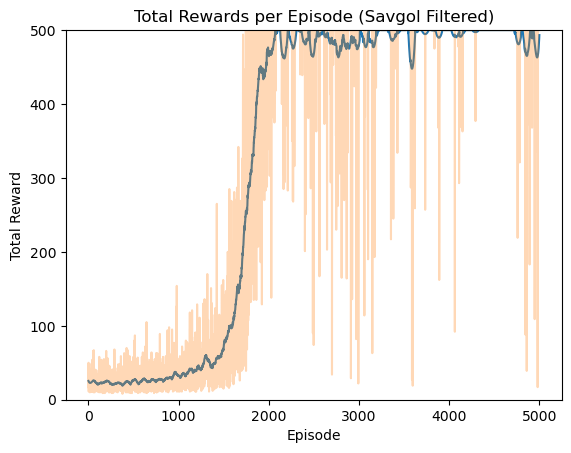

In [11]:
# Plot
plt.plot(savgol_filter(total_rewards, 101, 3), label="filtered")
plt.plot(total_rewards, alpha=0.3, label="raw")
plt.title("Total Rewards per Episode (Savgol Filtered)")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.ylim([0, 500])
plt.show()

In [13]:
# Render a single episode using the trained PPO agent
env = gym.make("CartPole-v1", render_mode="human")
ppo_agent = PPO(
    state_dim,
    action_dim,
    learning_rate_actor,
    learning_rate_critic,
    gamma,
    epochs,
    eps_clip,
)
ppo_agent.policy_old.load_state_dict(policy_state_dict)

observation, info = env.reset()
terminated = False
truncated = False

while not terminated and not truncated:
    with torch.no_grad():
        state_tensor = torch.FloatTensor(observation).to(device)
        action_probs = ppo_agent.policy_old.actor(state_tensor)
        # Select the most likely action (exploitation)
        action = torch.argmax(action_probs).item()

    next_observation, reward, terminated, truncated, info = env.step(action)
    observation = next_observation
    time.sleep(0.02)  # 50 FPS max

env.close()